Author: Doug Branton, Neven Caplar and the LINCC Frameworks team

Last updated: November 13, 2025

# Introduction to Nested-Pandas

This notebook explores the Nested-Pandas API, showing the basics of nesting data and touring the various ways of working with nested data.

In this notebook we'll show how to:
- Generate example data
- Understand nested-pandas dataframe
- Do filtering
- Run a function over nested dataframes
- Brin the result back and merge to our nested dataframe

## Exploring the NestedFrame Interface

In [1]:
import nested_pandas as npd
import pandas as pd
import numpy as np

from nested_pandas.utils import count_nested
from lsdb import ConeSearch

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Configuration settings
rcParams["savefig.dpi"] = 550
rcParams["font.size"] = 20
plt.rc("font", family="serif")
mpl.rcParams["axes.linewidth"] = 2

In [2]:
# Define the six fields from Data Preview 1 with RA and Dec coordinates
fields = {
    "ECDFS": (53.13, -28.10),  # Extended Chandra Deep Field South
    "EDFS": (59.10, -48.73),  # Euclid Deep Field South
    "Rubin_SV_38_7": (37.86, 6.98),  # Low Ecliptic Latitude Field
    "Rubin_SV_95_-25": (95.00, -25.00),  # Low Galactic Latitude Field
    "47_Tuc": (6.02, -72.08),  # 47 Tuc Globular Cluster
    "Fornax_dSph": (40.00, -34.45)  # Fornax Dwarf Spheroidal Galaxy
}

# Define a 0.2-degree (0.2*3600 arcseconds) search radius
radius_arcsec = 0.2 * 3600  # Convert 0.2 degree to arcseconds
# Create six cone searches
cones = {name: ConeSearch(ra=ra, dec=dec, radius_arcsec=radius_arcsec) for name, (ra, dec) in fields.items()}

In [3]:
# Load an example dataset
from nested_pandas.datasets import generate_data
ndf = generate_data(50,100, seed=1).rename({"nested": "lightcurve"}, axis=1)
ndf

a         b                                         lightcurve
0   0.417022  0.038734  [{t: 6.532898, flux: 77.388964, band: 'r'}; …]...
1   0.720324  1.357671  [{t: 10.541162, flux: 82.03493, band: 'r'}; …]...
..       ...       ...                                                ...
48  0.287775  0.005741  [{t: 11.19434, flux: 11.946375, band: 'r'}; …]...
49  0.130029  1.234290  [{t: 0.25112, flux: 94.006251, band: 'g'}; …] ...

[50 rows x 3 columns]

In [4]:
# Accessing an individual lightcurve dataframe
ndf["lightcurve"][0]

,t,flux,band
0,6.532898,77.388964,r
1,1.439486,55.886109,g
...,...,...,...
98,13.575110,76.549696,g
99,14.949946,14.803440,g


In [5]:
# flux is a sub-column of the "lightcurve" column
ndf["lightcurve.flux"]

0     77.388964
0     55.886109
        ...    
49    17.012447
49    86.404021
Name: flux, Length: 5000, dtype: double[pyarrow]

## Hands-on Scientific Example: Variability Analysis

### Load ZTF Timeseries Data

In [6]:
# only Load data around 
import lsdb

#ra_center, dec_center = cones["Rubin_SV_95_-25"].ra, cones["Rubin_SV_95_-25"].dec
# Load via LSDB, .compute() returns a NestedFrame to work with
# This may take a few minutes
ztf_ndf = lsdb.open_catalog('https://data.lsdb.io/hats/ztf_dr22/ztf_lc',
                            margin_cache='https://data.lsdb.io/hats/ztf_dr22/ztf_lc_10arcs',
                            search_filter=cones["Rubin_SV_95_-25"]).compute()
ztf_ndf.dtypes

objectid                    int64[pyarrow]
filterid                     int8[pyarrow]
objra                       float[pyarrow]
objdec                      float[pyarrow]
nepochs                     int64[pyarrow]
hmjd        list<element: double>[pyarrow]
mag          list<element: float>[pyarrow]
magerr       list<element: float>[pyarrow]
clrcoeff     list<element: float>[pyarrow]
catflags     list<element: int32>[pyarrow]
dtype: object

In [7]:
# The timeseries data in this dataset is stored as lists, we can convert these into a nested column

ztf_ndf = ztf_ndf.nest_lists(columns=["hmjd","mag","magerr","clrcoeff","catflags"], name="timeseries")
ztf_ndf

objectid  filterid      objra     objdec  nepochs  \
_healpix_29                                                                     
1450136709898271135  258108400000047         1  95.040352  -25.19565      157   
1450136709898294367  258208400000023         2  95.040352 -25.195646      457   
...                              ...       ...        ...        ...      ...   
1456155336767175581  258108100004227         1   94.99221 -24.804495       29   
1456155336769478700  258208100007410         2  94.992165 -24.804405      354   

                                                            timeseries  
_healpix_29                                                             
1450136709898271135  [{hmjd: 58205.13356, mag: 16.904661, magerr: 0...  
1450136709898294367  [{hmjd: 58397.52197, mag: 16.151007, magerr: 0...  
...                                                                ...  
1456155336767175581  [{hmjd: 58423.449, mag: 19.983234, magerr: 0.1...  
1456155336769478700  [{hmjd: 58397.52198, mag: 19.669369, magerr: 0...  

[6924 rows x 6 columns]

### Perform Initial Filtering

In [8]:
# First filter given brightness of observations

ztf_ndf = ztf_ndf.query("timeseries.mag < 20.0")
ztf_ndf

objectid  filterid      objra     objdec  nepochs  \
_healpix_29                                                                     
1450136709898271135  258108400000047         1  95.040352  -25.19565      157   
1450136709898294367  258208400000023         2  95.040352 -25.195646      457   
...                              ...       ...        ...        ...      ...   
1456155336767175581  258108100004227         1   94.99221 -24.804495       29   
1456155336769478700  258208100007410         2  94.992165 -24.804405      354   

                                                            timeseries  
_healpix_29                                                             
1450136709898271135  [{hmjd: 58205.13356, mag: 16.904661, magerr: 0...  
1450136709898294367  [{hmjd: 58397.52197, mag: 16.151007, magerr: 0...  
...                                                                ...  
1456155336767175581  [{hmjd: 58423.449, mag: 19.983234, magerr: 0.1...  
1456155336769478700  [{hmjd: 58397.52198, mag: 19.669369, magerr: 0...  

[6924 rows x 6 columns]

In [9]:
# nepochs provides the unmodified number of observations, 
# but now that we've rejected some observations we'll need to recompute the counts

ztf_ndf = count_nested(ztf_ndf, "timeseries")
ztf_ndf

objectid  filterid      objra     objdec  nepochs  \
_healpix_29                                                                     
1450136709898271135  258108400000047         1  95.040352  -25.19565      157   
1450136709898294367  258208400000023         2  95.040352 -25.195646      457   
...                              ...       ...        ...        ...      ...   
1456155336767175581  258108100004227         1   94.99221 -24.804495       29   
1456155336769478700  258208100007410         2  94.992165 -24.804405      354   

                                                            timeseries  \
_healpix_29                                                              
1450136709898271135  [{hmjd: 58205.13356, mag: 16.904661, magerr: 0...   
1450136709898294367  [{hmjd: 58397.52197, mag: 16.151007, magerr: 0...   
...                                                                ...   
1456155336767175581  [{hmjd: 58423.449, mag: 19.983234, magerr: 0.1...   
1456155336769478700  [{hmjd: 58397.52198, mag: 19.669369, magerr: 0...   

                     n_timeseries  
_healpix_29                        
1450136709898271135           157  
1450136709898294367           457  
...                           ...  
1456155336767175581             2  
1456155336769478700           353  

[6978 rows x 7 columns]

In [10]:
# Now we can query by the newly added "n_timeseries" column
ztf_ndf = ztf_ndf.query("n_timeseries > 50")
ztf_ndf

objectid  filterid      objra     objdec  nepochs  \
_healpix_29                                                                     
1450136709898271135  258108400000047         1  95.040352  -25.19565      157   
1450136709898294367  258208400000023         2  95.040352 -25.195646      457   
...                              ...       ...        ...        ...      ...   
1456155315393785536  258208100007398         2  94.959763 -24.803455      364   
1456155336769478700  258208100007410         2  94.992165 -24.804405      354   

                                                            timeseries  \
_healpix_29                                                              
1450136709898271135  [{hmjd: 58205.13356, mag: 16.904661, magerr: 0...   
1450136709898294367  [{hmjd: 58397.52197, mag: 16.151007, magerr: 0...   
...                                                                ...   
1456155315393785536  [{hmjd: 58397.52198, mag: 19.500437, magerr: 0...   
1456155336769478700  [{hmjd: 58397.52198, mag: 19.669369, magerr: 0...   

                     n_timeseries  
_healpix_29                        
1450136709898271135           157  
1450136709898294367           457  
...                           ...  
1456155315393785536           364  
1456155336769478700           353  

[2570 rows x 7 columns]

### Calculate Periodograms for all Lightcurves

In [11]:
from astropy.timeseries import LombScargle

# Define a periodogram calculator function, using astropy's LombScargle
def extract_period(time, mag, error):
    ls = LombScargle(time, mag, error)
    freq, power = ls.autopower()
    argmax = np.argmax(power)
    period = 1.0 / freq[argmax]
    false_alarm_prob = ls.false_alarm_probability(power[argmax])
    return {"period": period, "false_alarm_prob": false_alarm_prob}

# Apply our function to each timeseries via reduce
periods_ndf = ztf_ndf.reduce(
    extract_period,
    # Column names specifying function arguments
    "timeseries.hmjd",
    "timeseries.mag",
    "timeseries.magerr",
)
periods_ndf

/opt/lsst/software/stack/conda/envs/lsst-scipipe-12.0.0/lib/python3.13/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:251: RuntimeWarning: invalid value encountered in scalar power
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)
/opt/lsst/software/stack/conda/envs/lsst-scipipe-12.0.0/lib/python3.13/site-packages/astropy/timeseries/periodograms/lombscargle/_statistics.py:140: RuntimeWarning: invalid value encountered in scalar power
  return (1 - z) ** (0.5 * Nk)


,period,false_alarm_prob
_healpix_29,,
1450136709898271135,624.581469,9.171817e-01
1450136709898294367,6.037760,9.113926e-01
...,...,...
1456155315393785536,2.248559,4.301131e-14
1456155336769478700,2.496738,1.902847e-10


In [12]:
# Join our result ndf back to our main ndf
ztf_ndf_w_periods = ztf_ndf.join(periods_ndf)
ztf_ndf_w_periods.sort_values("false_alarm_prob", ascending=True)

objectid  filterid      objra     objdec  nepochs  \
_healpix_29                                                                     
1450136924632759526  258208100018921         2  95.111443 -25.159864      392   
1456150499664383216  258208100023049         2  94.796219 -24.997358      285   
...                              ...       ...        ...        ...      ...   
1456144920907915081  258208100036293         2  95.130653 -25.073711       76   
1456148725535817846  258208100037777         2  95.060074 -24.884846       60   

                                                            timeseries  \
_healpix_29                                                              
1450136924632759526  [{hmjd: 58397.52196, mag: 18.673216, magerr: 0...   
1456150499664383216  [{hmjd: 58397.52199, mag: 19.957094, magerr: 0...   
...                                                                ...   
1456144920907915081  [{hmjd: 58425.45407, mag: 19.636189, magerr: 0...   
1456148725535817846  [{hmjd: 58397.52197, mag: 19.560516, magerr: 0...   

                     n_timeseries       period  false_alarm_prob  
_healpix_29                                                       
1450136924632759526           392     2.038138      1.381789e-72  
1456150499664383216           247  1531.268854      2.356597e-70  
...                           ...          ...               ...  
1456144920907915081            64    12.197638               NaN  
1456148725535817846            57     0.847256               NaN  

[2894 rows x 9 columns]

### Visualizing Results

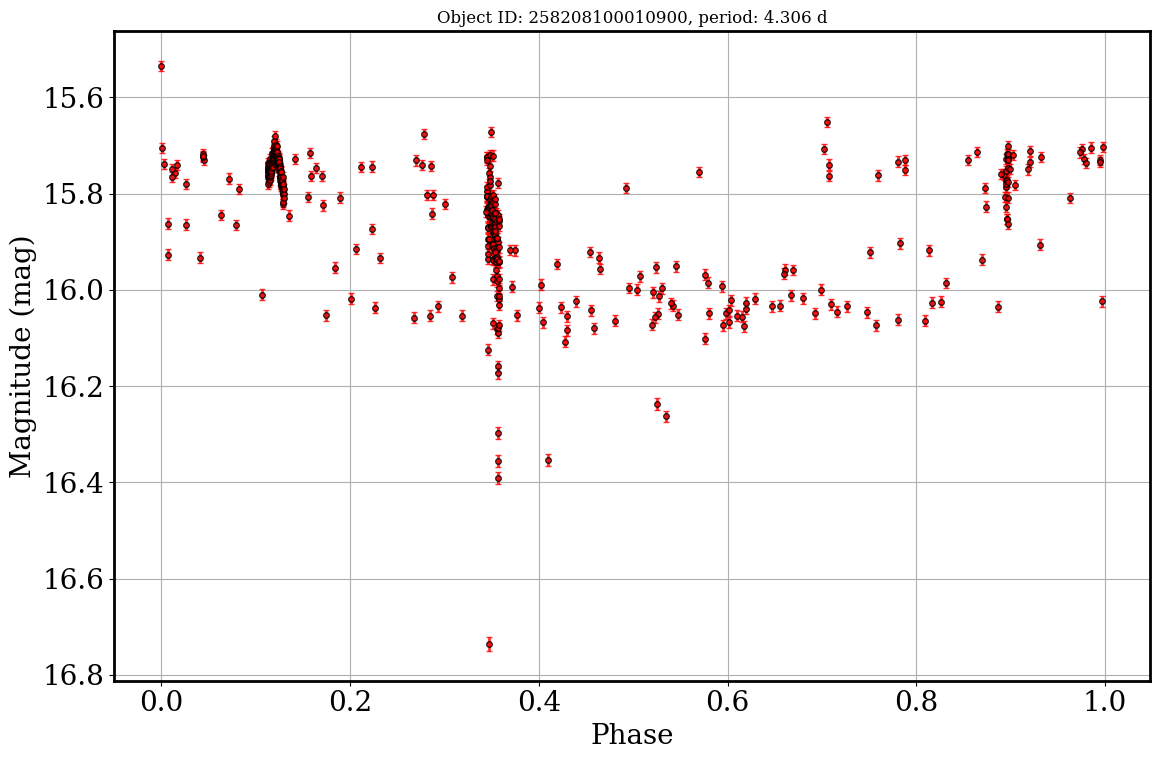

In [13]:
# Pick an interesting result by eye
interesting_idx = 1456145241786570789

row = ztf_ndf_w_periods.loc[interesting_idx]
lc = row.timeseries

peak_mjd = lc["hmjd"][lc["mag"].idxmin()]
lc["phase"] = (lc["hmjd"] - peak_mjd) % row.period / row.period

# Create figure with nice styling
fig, ax = plt.subplots(figsize=(12, 8))

ax.errorbar(
    lc["phase"],
    lc["mag"],
    yerr=lc["magerr"],
    fmt="o",
    color="red",
    ecolor="red",
    elinewidth=2,
    capsize=2,
    alpha=0.8,
    markeredgecolor="k",
    markersize=4,
)

ax.invert_yaxis()
ax.set_xlabel("Phase")
ax.set_ylabel("Magnitude (mag)")
ax.set_title(f"Object ID: {row.objectid}, period: {row.period:.3f} d", fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

### Using Results to Modify our NestedFrame

In [14]:
# Like any normal column, we can now use this computed value to filter
# In this case, we can filter out objects with a high false alarm probability
ztf_ndf_false_filtered = ztf_ndf_w_periods.query("false_alarm_prob < 0.05")
ztf_ndf_false_filtered

objectid  filterid      objra     objdec  nepochs  \
_healpix_29                                                                     
1450136723508654756  258108400000086         1  95.011963 -25.199055      157   
1450136723508677721  258208400000085         2  95.011955 -25.199051      447   
...                              ...       ...        ...        ...      ...   
1456155315393785536  258208100007398         2  94.959763 -24.803455      364   
1456155336769478700  258208100007410         2  94.992165 -24.804405      354   

                                                            timeseries  \
_healpix_29                                                              
1450136723508654756  [{hmjd: 58423.44054, mag: 17.943167, magerr: 0...   
1450136723508677721  [{hmjd: 58397.52197, mag: 17.463593, magerr: 0...   
...                                                                ...   
1456155315393785536  [{hmjd: 58397.52198, mag: 19.500437, magerr: 0...   
1456155336769478700  [{hmjd: 58397.52198, mag: 19.669369, magerr: 0...   

                     n_timeseries      period  false_alarm_prob  
_healpix_29                                                      
1450136723508654756           157  385.829051      5.187533e-04  
1450136723508677721           447    3.546498      8.961517e-04  
...                           ...         ...               ...  
1456155315393785536           364    2.248559      4.301131e-14  
1456155336769478700           353    2.496738      1.902847e-10  

[1318 rows x 9 columns]

# Problem 3

## Use quality flags to clean photometry

In the work above, we've forgotten an important pre-processing step, filtering our photometry based on quality flags. For this exercise, compute periodograms for the ZTF DR22 lightcurves again, but this time only using photometry with no quality flags set in `catflags`. Optionally, look at the same object in this notebook at the end to see how the lightcurve has changed by including a quality flag cut. Feel free to re-use any and all code shown above in the result.